# NAIVE BAYES

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/tybrob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [3]:
def stemming(content):
    port_stem = PorterStemmer()
    stop_words = stopwords.words('english')

    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stop_words]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submit = pd.read_csv('data/submit.csv')

test = pd.merge(test,submit,on='id')
total = pd.concat([train,test])

total = total.fillna('')
total = total.loc[total['text'] != '']

In [5]:
total['text'] = total['text'].apply(stemming)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer()

X = total['text'].values
Y = total['label'].values
X = vectorizer.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, stratify=Y, random_state=42)

In [7]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)

In [36]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

param_grid = {
  'alpha': np.arange(0.1, 1.3, 0.1),
  'fit_prior': [True, False],
}

model_nb = GridSearchCV(estimator=MultinomialNB(), param_grid = param_grid, cv = skf, n_jobs=-1, verbose=1)
model_nb.fit(X_train, Y_train)

print(model_nb.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': True}
CPU times: user 142 ms, sys: 44.2 ms, total: 186 ms
Wall time: 3.39 s


In [24]:
%%time
from sklearn.metrics import accuracy_score,classification_report

nb = MultinomialNB(alpha=0.1,fit_prior=True)

nb.fit(X_train,Y_train)

X_train_prediction = nb.predict(X_train)

print('Accuracy score on training set:',accuracy_score(X_train_prediction, Y_train))

Accuracy score on training set: 0.9104420102383443
CPU times: user 68.7 ms, sys: 14 µs, total: 68.8 ms
Wall time: 77.8 ms


In [11]:
%%time
from sklearn.metrics import classification_report

X_test_prediction = nb.predict(X_test)

print(classification_report(X_test_prediction, Y_test))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      4324
           1       0.78      0.89      0.83      3463

    accuracy                           0.84      7787
   macro avg       0.84      0.85      0.84      7787
weighted avg       0.85      0.84      0.84      7787

CPU times: user 24.1 ms, sys: 3.95 ms, total: 28.1 ms
Wall time: 31.9 ms


<AxesSubplot:title={'center':'Grid search results'}, xlabel='alpha', ylabel='Mean score'>

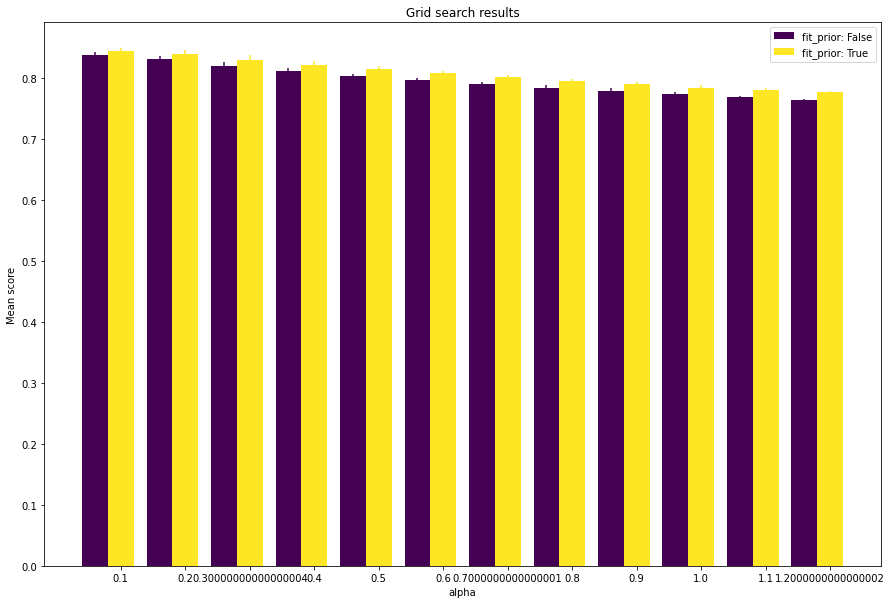

In [37]:
from sklearn_evaluation import plot
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))
plot.grid_search(model_nb.cv_results_, change='alpha', kind='bar',)

# SVM

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
train = pd.read_csv(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\data\train.csv')
test = pd.read_csv(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\data\test.csv')
submit = pd.read_csv(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\data\submit.csv')
test = pd.merge(test,submit,on='id')
total = pd.concat([train,test])
total = total.dropna(subset=['text', 'label'])

In [9]:
total.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25954 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25954 non-null  int64 
 1   title   25274 non-null  object
 2   author  23540 non-null  object
 3   text    25954 non-null  object
 4   label   25954 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


In [11]:
texts = np.asarray(total['text'])
labels = np.asarray(total['label'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.25, random_state=43)

In [14]:
%%time
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english').fit(X_train)

Wall time: 18.9 s


In [15]:
%%time
X_train_tr = vectorizer.transform(X_train)
X_test_tr = vectorizer.transform(X_test)

Wall time: 25.1 s


In [16]:
%%time
vec_all = TfidfVectorizer(strip_accents='unicode', stop_words='english').fit(texts)

Wall time: 26.4 s


In [17]:
from nltk.stem import PorterStemmer
import re

In [18]:
%%time
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

port_stem = PorterStemmer()

def WordTokenizer(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content).lower().split()
    #stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords]
    stemmed_content = [port_stem.stem(word) for word in stemmed_content]
    return stemmed_content

vect = TfidfVectorizer(tokenizer=WordTokenizer, strip_accents='unicode', stop_words='english')

Wall time: 0 ns


In [19]:
%%time
vect.fit(X_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi

Wall time: 5min 35s


TfidfVectorizer(stop_words='english', strip_accents='unicode',
                tokenizer=<function WordTokenizer at 0x00000247980669D0>)

In [20]:
%%time
X_train_trans = vect.transform(X_train)

Wall time: 5min 38s


In [21]:
%%time
X_test_trans = vect.transform(X_test)

Wall time: 1min 49s


Αποθηκεύουμε τον vectorizer που θα χρησιμοποιήσουμε ως pkl αρχείο για να μην τον ξαναδημιουργούμε κάθε φορά που θέλουμε να τον χρησιμοποιήσουμε.

In [2]:
import joblib

In [23]:
joblib.dump(vect, r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\notebook\vectorizer.pkl')

['C:\\Users\\user\\Desktop\\Μεταπτυχιακό\\Εργασίες\\Data Mining\\Χαλκίδη\\notebook\\vectorizer.pkl']

Για να τον ξαναχρησιμοποιήσουμε γράφουμε vectorizer = joblib.load(path_to_pkl)

Ομοίως μπορούμε να αποθηκεύσουμε και τα X_train_trans και X_test_trans για τους ίδιους λόγους.

In [24]:
joblib.dump(X_train_trans, r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\notebook\X_train_trans.pkl')
joblib.dump(X_test_trans, r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\notebook\X_test_trans.pkl')

['C:\\Users\\user\\Desktop\\Μεταπτυχιακό\\Εργασίες\\Data Mining\\Χαλκίδη\\notebook\\X_test_trans.pkl']

In [25]:
joblib.dump(y_train, r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\notebook\y_train.pkl')
joblib.dump(y_test, r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\notebook\y_test.pkl')

['C:\\Users\\user\\Desktop\\Μεταπτυχιακό\\Εργασίες\\Data Mining\\Χαλκίδη\\notebook\\y_test.pkl']

In [3]:
X_train_trans = joblib.load(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\notebook\X_train_trans.pkl')
X_test_trans = joblib.load(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\notebook\X_test_trans.pkl')

In [4]:
y_train = joblib.load(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\notebook\y_train.pkl')
y_test = joblib.load(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\notebook\y_test.pkl')

In [5]:
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1

In [99]:
%%time
C = [.75, 1, 1.25]
times_ = []
train_acc = []
test_acc = []
pre = []
rec = []
f1_sc = []
for c in C:
    print(c)
    svm_cl = SVC(kernel='rbf', C=c)
    tic = time()
    svm_cl.fit(X_train_trans, y_train)
    toc = time()
    times_.append(float(toc-tic))
    train_acc.append(svm_cl.score(X_train_trans, y_train))
    test_acc.append(svm_cl.score(X_test_trans, y_test))
    pre.append(precision(y_test, svm_cl.predict(X_test_trans)))
    rec.append(recall(y_test, svm_cl.predict(X_test_trans)))
    f1_sc.append(f1(y_test, svm_cl.predict(X_test_trans)))

0.75
1
1.25
Wall time: 2h 14min 34s


Βλέπουμε ότι η εκπαίδευση του κατηγοριοποιητή χρησιμοποιώντας ως πυρήνα τον RBF και σταθερά γ την default τιμή η οποία ισούται με 1 / (n_features * X.var()) (απ' το documentation της βιβλιοθήκης scikit-learn), είναι εξαιρετικά αργή. Παρακάτω θα δοκιμάσουμε με διαφορετικές τιμές υπερπαραμέτρων για τον RBF.

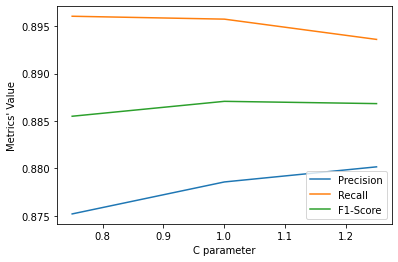

In [102]:
plt.plot(C, pre)
plt.plot(C, rec)
plt.plot(C, f1_sc)
plt.legend(['Precision', 'Recall', 'F1-Score'])
plt.xlabel('C parameter')
plt.ylabel('Metrics\' Value')
plt.show()

Βλέπουμε το F1-Score είναι σχετικά υψηλό και οι τιμές των precision και recall είναι αρκετά κοντά (γεγονός που αποτελεί επιθυμητό μέτρο).

Σύμφωνα με το documentation της sklearn.svm.SVC, ο παραπάνω τρόπος υλοποίησης κατηγοριοποίησης με SVM είναι κάκιστος ('The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples.'). Ως εκ τούτου, στηριζόμενοι πάλι στο documentation θα χρησιμοποιήσουμε τις κλάσεις sklearn.svm.LinearSVC και sklearn.linear_model.SGDClassifier για να υλοποιήσουμε γραμμική SVM και Stochastic Gradient Descent αντίστοιχα.

In [37]:
from sklearn.svm import LinearSVC

In [34]:
lsvc = LinearSVC(C=2)
lsvc.fit(X_train_trans, y_train)

LinearSVC(C=2)

In [35]:
lsvc.score(X_test_trans, y_test)

0.8631530282015719

In [109]:
%%time
C = np.linspace(.1, 10, 100)
scores_lvc = []
times_lvc = []
for c in C:
    lsvc = LinearSVC(C=c)
    tic = time()
    lsvc.fit(X_train_trans, y_train)
    toc = time()
    times_lvc.append(float(toc-tic))
    scores_lvc.append(lsvc.score(X_test_trans, y_test))

Wall time: 5min 12s


Βλέπουμε ότι χρησιμοποιώντας την LinearSVC χρειάστηκαν περίπου 5 λεπτά για να εκπαιδεύσουμε και να δοκιμάσουμε 100 μοντέλα.

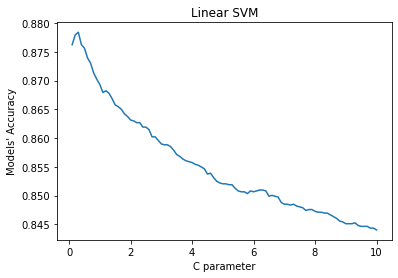

In [110]:
plt.plot(C, scores_lvc)
plt.xlabel('C parameter')
plt.ylabel('Models\' Accuracy')
plt.title('Linear SVM')
plt.show()

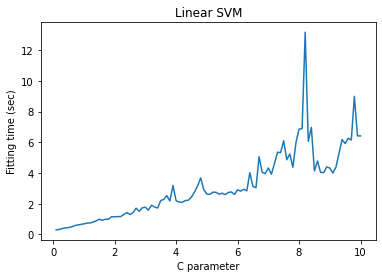

In [111]:
plt.plot(C, times_lvc)
plt.xlabel('C parameter')
plt.ylabel('Fitting time (sec)')
plt.title('Linear SVM')
plt.show()          

In [116]:
print('Mean Fiatting Time:', np.mean(np.asarray(times_)), '\nFitting Time StD:  ', np.std(np.asarray(times_)))

Mean Fiatting Time: 3.114066531658173 
Fitting Time StD:   2.1703409899140294


Βλέπουμε ότι καθώς αυξάνει το C, ταυτόχρονα αυξάνει κι ο χρόνος εκπαίδευσης. Αυτό ενδεχομένως να οφείλεται και στην κατανάλωση της RAM.

Τώρα θα δούμε πως συμπεριφέρεται η Linear SVM για C στο (0.1, 1.1).

In [70]:
%%time
C = np.linspace(.1, 1.1, 10)
scores_ = []
train_ = []
times_ = []
for c in C:
    lsvc = LinearSVC(C=c)
    tic = time()
    lsvc.fit(X_train_trans, y_train)
    toc = time()
    times_.append(float(toc-tic))
    scores_.append(lsvc.score(X_test_trans, y_test))
    train_.append(lsvc.score(X_train_trans, y_train))

Wall time: 6.26 s


In [71]:
scores_, train_

([0.8762521189705655,
  0.8779472954230236,
  0.8773308676221298,
  0.8757897981198952,
  0.8736323008167668,
  0.8727076591154261,
  0.8722453382647557,
  0.8703960548620743,
  0.8693173062105101,
  0.867930343658499],
 [0.9120986385820704,
  0.9308502440277421,
  0.9407654764962754,
  0.9479064988440791,
  0.9536604161315181,
  0.9582327254045723,
  0.9620344207552016,
  0.965630619059851,
  0.9687130747495505,
  0.971435910608785])

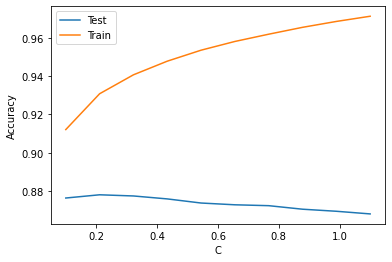

In [72]:
plt.plot(C, scores_, label='Test')
plt.plot(C, train_, label='Train')
plt.legend()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

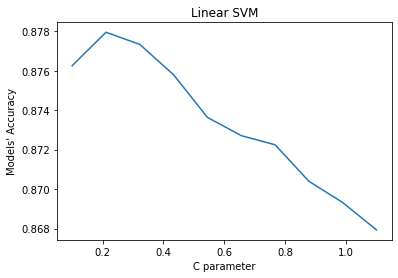

In [78]:
plt.plot(C, scores_)
plt.xlabel('C parameter')
plt.ylabel('Models\' Accuracy')
plt.title('Linear SVM')
plt.show()

Βλέπουμε μεγιστοποίηση της ακρίβειας για C=0.3.

In [76]:
from sklearn.svm import LinearSVC
lv = LinearSVC(C=.3).fit(X_train_trans, y_train)
lv.score(X_test_trans, y_test)

0.8779472954230236

In [79]:
%%time
lv = LinearSVC(C=.3).fit(X_train_trans, y_train)

Wall time: 411 ms


In [80]:
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1

In [82]:
print('Precision:', precision(y_test, lv.predict(X_test_trans)), '\nRecall:', recall(y_test, lv.predict(X_test_trans)), '\nF1-Score:', f1(y_test, lv.predict(X_test_trans)))

Precision: 0.8712189278227014 
Recall: 0.8893304799755426 
F1-Score: 0.8801815431164901


In [125]:
from sklearn.model_selection import cross_val_score

Τώρα θα προσπαθήσουμε να εφαρμόσουμε kernel SVM σε ανεκτούς χρόνους. Για να το κάνουμε αυτό θα επιχειρήσουμε SVD για να επιτύχουμε dimensionality reduction.

In [6]:
from sklearn.decomposition import TruncatedSVD as SVD

In [10]:
%%time
svd_tr = SVD(n_components=100)
svd_tr.fit(X_train_trans)

Wall time: 11.1 s


TruncatedSVD(n_components=100)

In [12]:
%%time
X_train_svd = svd_tr.transform(X_train_trans)
X_test_svd = svd_tr.transform(X_test_trans)

Wall time: 694 ms


In [14]:
%%time
svc = SVC(kernel='rbf').fit(X_train_svd, y_train)

Wall time: 24.9 s


Βλέπουμε ότι το μοντέλο εκπαιδεύτηκε εξαιρετικά γρήγορα χρησιμοποιώντας τα 100 κυριώτερα components.

In [15]:
%%time
svc.score(X_test_svd, y_test)

Wall time: 7.81 s


0.8690090923100632

Βλέπουμε επίσης ότι παίρνουμε και σχετικά καλή ακρίβεια για τις default τιμές των υπερπαραμέτρων στην υλοποίηση. Παρακάτω θα δοκιμάσουμε να κάνουμε tuning για τη υπερπαράμετρο γ όταν χρησιμοποιούμε τον RBF πυρήνα.

In [18]:
%%time
from time import time
gamma = np.linspace(.1, 2.1, 100)
times_ = []
acc_scores_ = []
for g in gamma:
    tic = time()
    svc = SVC(kernel='rbf', gamma=g).fit(X_train_svd, y_train)
    toc = time()
    times_.append(toc-tic)
    acc_scores_.append(svc.score(X_test_svd, y_test))

Wall time: 1h 2min 48s


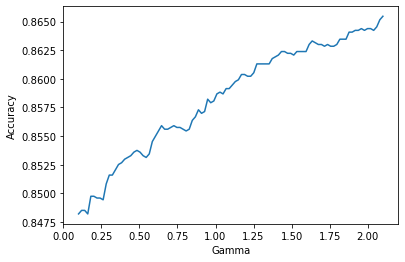

In [19]:
plt.plot(gamma, acc_scores_)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.show()

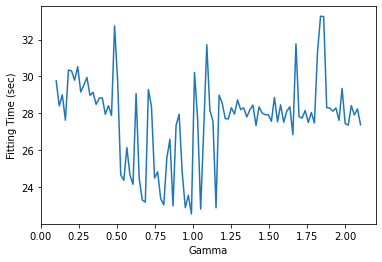

In [22]:
plt.plot(gamma, times_)
plt.xlabel('Gamma')
plt.ylabel('Fitting Time (sec)')
plt.show()

Παρατηρούμε ότι η ακρίβεια φαλινεται να αυξάνεται λογαριθμικά σε σχέση με την τιμή της υπερπαραμέτρου γ.

In [24]:
acc_scores_ = np.asarray(acc_scores_)

In [26]:
gamma[acc_scores_.argmax()]

2.1

In [27]:
acc_scores_[acc_scores_.argmax()]

0.8654646324549237

In [29]:
%%time
from time import time
gamma = np.linspace(2, 10, 9)
times_sparse = []
acc_scores_sparse = []
for g in gamma:
    tic = time()
    svc = SVC(kernel='rbf', gamma=g).fit(X_train_svd, y_train)
    toc = time()
    times_sparse.append(toc-tic)
    acc_scores_sparse.append(svc.score(X_test_svd, y_test))

Wall time: 8min 12s


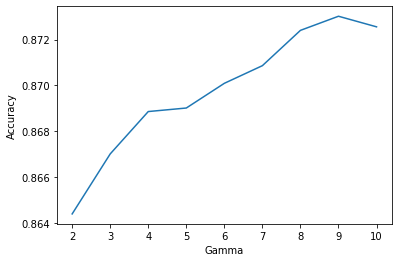

In [30]:
plt.plot(gamma, acc_scores_sparse)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.show()

In [40]:
acc_scores_sparse

[0.8643858838033596,
 0.8670057019571583,
 0.8688549853598397,
 0.8690090923100632,
 0.8700878409616274,
 0.8708583757127446,
 0.8723994452149791,
 0.873015873015873,
 0.8725535521652027]

In [43]:
times_sparse

[27.272191524505615,
 27.889263153076172,
 28.737401247024536,
 34.66989231109619,
 36.12515687942505,
 41.849050521850586,
 52.31587266921997,
 60.83110809326172,
 72.41778683662415]

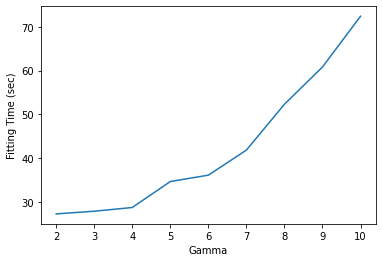

In [31]:
plt.plot(gamma, times_sparse)
plt.xlabel('Gamma')
plt.ylabel('Fitting Time (sec)')
plt.show()

Βλέπουμε ότι επιλέγοντας γ>2 συνεχίζεται η αύξηση στην ακρίβεια η οποία πιάνει μέγιστη τιμή για γ=9. Ταυτόχρονα βλέπουμε ότι έχουμε κι ανάλογη αύξηση στο χρόνο εκπαίδευσης.

In [33]:
acc_scores_100 = np.asarray(acc_scores_sparse)

In [34]:
acc_scores_100[acc_scores_100.argmax()]

0.873015873015873

Επιλέγοντας τώρα να εφαρμόσουμε την SVD κρατώντας τα 1000 σημαντικότερα χαρακτηριστικά, για τις διάφορες τιμές της υπερπαραμέτρου γ παίρνουμε:

In [48]:
svd_tr1000 = SVD(n_components=1000)
svd_tr1000.fit(X_train_trans)

TruncatedSVD(n_components=1000)

In [49]:
X_train_1000 = svd_tr1000.transform(X_train_trans)
X_test_1000 = svd_tr1000.transform(X_test_trans)

In [51]:
%%time
from time import time
gamma = np.linspace(.1, 2.1, 10)
times_1000 = []
acc_scores_1000 = []
for g in gamma:
    tic = time()
    svc = SVC(kernel='rbf', gamma=g).fit(X_train_1000, y_train)
    toc = time()
    times_1000.append(toc-tic)
    acc_scores_1000.append(svc.score(X_test_1000, y_test))

Wall time: 44min 28s


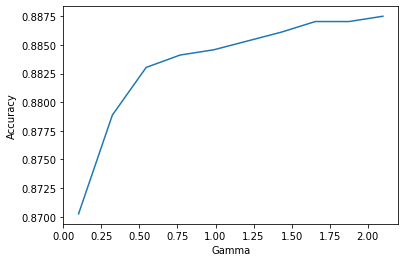

In [52]:
plt.plot(gamma, acc_scores_1000)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.show()

In [63]:
acc_scores_1000

[0.8702419479118508,
 0.8788719371243643,
 0.8830328247803976,
 0.8841115734319618,
 0.8845738942826321,
 0.8853444290337494,
 0.8861149637848666,
 0.8870396054862074,
 0.8870396054862074,
 0.8875019263368777]

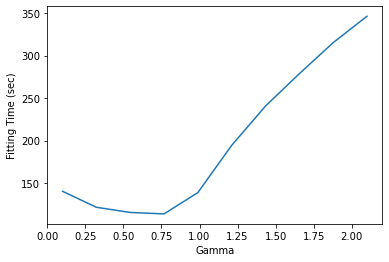

In [53]:
plt.plot(gamma, times_1000)
plt.xlabel('Gamma')
plt.ylabel('Fitting Time (sec)')
plt.show()

In [62]:
times_1000

[140.47962093353271,
 121.70309734344482,
 115.63862705230713,
 113.90063714981079,
 138.91966080665588,
 194.41938424110413,
 240.61607718467712,
 278.625061750412,
 315.07259368896484,
 346.2211081981659]

In [54]:
%%time
from time import time
gamma = np.linspace(2, 10, 9)
times_1000_sparse = []
acc_scores_1000_sparse = []
for g in gamma:
    tic = time()
    svc = SVC(kernel='rbf', gamma=g).fit(X_train_1000, y_train)
    toc = time()
    times_1000_sparse.append(toc-tic)
    acc_scores_1000_sparse.append(svc.score(X_test_1000, y_test))

Wall time: 1h 45min 2s


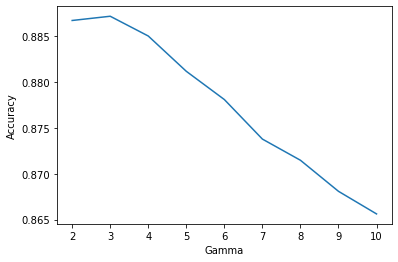

In [60]:
plt.plot(gamma, acc_scores_1000_sparse)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.show()

In [61]:
acc_scores_1000_sparse

[0.8867313915857605,
 0.8871937124364309,
 0.8850362151333026,
 0.8811835413777162,
 0.8781014023732471,
 0.8737864077669902,
 0.8714748035136385,
 0.8680844506087224,
 0.8656187394051472]

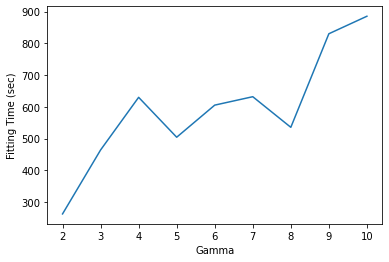

In [58]:
plt.plot(gamma, times_1000_sparse)
plt.xlabel('Gamma')
plt.ylabel('Fitting Time (sec)')
plt.show()

In [59]:
times_1000_sparse

[262.7839901447296,
 464.15295028686523,
 629.8963875770569,
 504.26948857307434,
 605.3360419273376,
 631.8490562438965,
 535.4635112285614,
 830.054206609726,
 885.2075378894806]

# Logistic Regression

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
train = pd.read_csv(r'C:/Users/billg/JNfolder/train.csv')
test = pd.read_csv(r'C:/Users/billg/JNfolder/test.csv')
submit = pd.read_csv(r'C:/Users/billg/JNfolder/submit.csv')
test = pd.merge(test,submit,on='id')
total = pd.concat([train,test])
total = total.dropna(subset=['text', 'label'])

In [3]:
total.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
total.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25954 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25954 non-null  int64 
 1   title   25274 non-null  object
 2   author  23540 non-null  object
 3   text    25954 non-null  object
 4   label   25954 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


In [5]:
texts = np.asarray(total['text'])
labels = np.asarray(total['label'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.25, random_state=43)

In [7]:
%%time
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english').fit(X_train)

Wall time: 19.1 s


In [8]:
%%time
X_train_tr = vectorizer.transform(X_train)
X_test_tr = vectorizer.transform(X_test)

Wall time: 24.8 s


In [9]:
%%time
vec_all = TfidfVectorizer(strip_accents='unicode', stop_words='english').fit(texts)

Wall time: 26.1 s


In [10]:
from nltk.stem import PorterStemmer
import re

In [11]:
%%time
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

port_stem = PorterStemmer()

def WordTokenizer(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content).lower().split()
    #stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords]
    stemmed_content = [port_stem.stem(word) for word in stemmed_content]
    return stemmed_content

vect = TfidfVectorizer(tokenizer=WordTokenizer, strip_accents='unicode', stop_words='english')

Wall time: 0 ns


In [12]:
%%time
vect.fit(X_train)

C:\Users\billg\anaconda3\envs\jupytenotebook\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\billg\anaconda3\envs\jupytenotebook\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher',

Wall time: 4min 5s


TfidfVectorizer(stop_words='english', strip_accents='unicode',
                tokenizer=<function WordTokenizer at 0x0000028C82B9EF70>)

In [13]:
%%time
X_train_trans = vect.transform(X_train)

Wall time: 3min 48s


In [14]:
%%time
X_test_trans = vect.transform(X_test)

Wall time: 1min 13s


In [15]:
import joblib

In [16]:
joblib.dump(vect, r'C:/Users/billg/JNfolder/vectorizer.pkl')
joblib.dump(X_train_trans, r'C:/Users/billg/JNfolder/X_train_trans.pkl')
joblib.dump(X_test_trans, r'C:/Users/billg/JNfolder/X_test_trans.pkl')
joblib.dump(y_train, r'C:/Users/billg/JNfolder/y_train.pkl')
joblib.dump(y_test, r'C:/Users/billg/JNfolder/y_test.pkl')

['C:/Users/billg/JNfolder/y_test.pkl']

In [17]:
X_train_trans = joblib.load(r'C:/Users/billg/JNfolder/X_train_trans.pkl')
X_test_trans = joblib.load(r'C:/Users/billg/JNfolder/X_test_trans.pkl')
y_train = joblib.load(r'C:/Users/billg/JNfolder/y_train.pkl')
y_test = joblib.load(r'C:/Users/billg/JNfolder/y_test.pkl')

In [18]:
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1

In [19]:
%%time
C = [.75, 1, 1.25]
times_ = []
train_acc = []
test_acc = []
pre = []
rec = []
f1_sc = []
for c in C:
    print(c)
    lgR = LogisticRegression(C=c)
    tic = time()
    lgR.fit(X_train_trans, y_train)
    toc = time()
    times_.append(float(toc-tic))
    train_acc.append(lgR.score(X_train_trans, y_train))
    test_acc.append(lgR.score(X_test_trans, y_test))
    pre.append(precision(y_test, lgR.predict(X_test_trans)))
    rec.append(recall(y_test, lgR.predict(X_test_trans)))
    f1_sc.append(f1(y_test, lgR.predict(X_test_trans)))

0.75
1
1.25
Wall time: 9.32 s


λέπουμε ότι η εκπαίδευση του κατηγοριοποιητή είναι αρκετά γρήγορη.

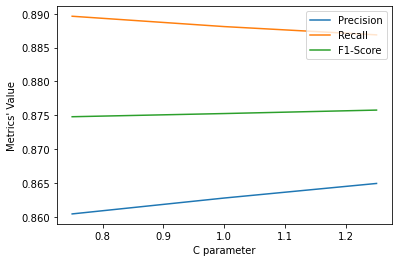

In [20]:
plt.plot(C, pre)
plt.plot(C, rec)
plt.plot(C, f1_sc)
plt.legend(['Precision', 'Recall', 'F1-Score'])
plt.xlabel('C parameter')
plt.ylabel('Metrics\' Value')
plt.show()

Βλέπουμε το F1-Score είναι σχετικά υψηλό και οι τιμές των precision και recall είναι αρκετά κοντά (γεγονός που αποτελεί επιθυμητό μέτρο).

In [29]:
%%time
C = np.linspace(.1, 10, 100)
scores_ = []
times_ = []
for c in C:
    lgR = LogisticRegression(C=c , max_iter = 1000)
    tic = time()
    lgR.fit(X_train_trans, y_train)
    toc = time()
    times_.append(float(toc-tic))
    scores_.append(lgR.score(X_test_trans, y_test))

Wall time: 9min 9s


Βλέπουμε ότι χρησιμοποιώντας την LogisticRegression χρειάστηκαν περίπου 9 λεπτά για να εκπαιδεύσουμε και να δοκιμάσουμε 100 μοντέλα.

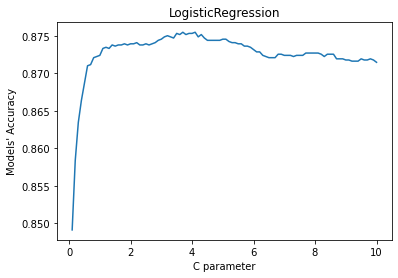

In [30]:
plt.plot(C, scores_)
plt.xlabel('C parameter')
plt.ylabel('Models\' Accuracy')
plt.title('LogisticRegression')
plt.show()

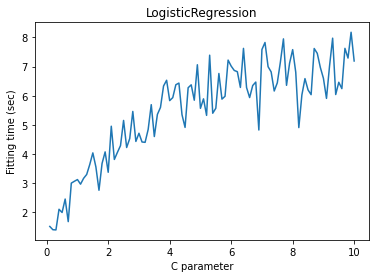

In [31]:
plt.plot(C, times_)
plt.xlabel('C parameter')
plt.ylabel('Fitting time (sec)')
plt.title('LogisticRegression')
plt.show()  

In [32]:
print('Mean Fiatting Time:', np.mean(np.asarray(times_)), '\nFitting Time StD:  ', np.std(np.asarray(times_)))

Mean Fiatting Time: 5.486042847633362 
Fitting Time StD:   1.6719930240462406


In [33]:
model = LogisticRegression(C=1)
model.fit(X_train_trans, y_train)
predicted_value = model.predict(X_test_trans)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)
print(predicted_value)

0.8722700895813237
[1 1 1 ... 1 0 1]


<AxesSubplot:>

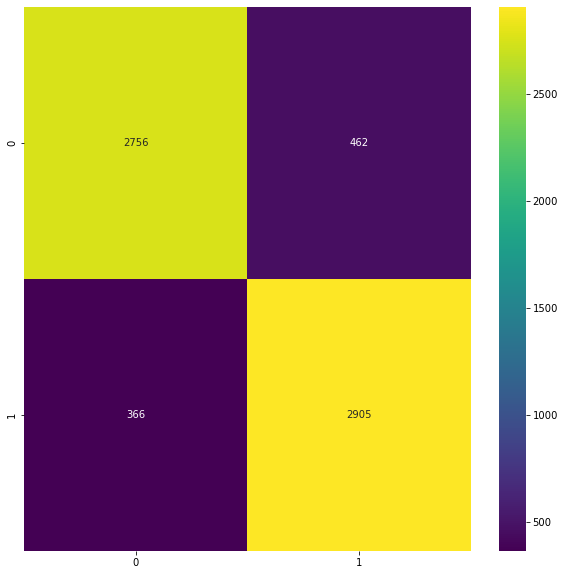

In [34]:
cm = confusion_matrix(list(y_test), predicted_value)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='viridis')

2905 Fake News have been Classified as Fake, while 2756 Real News have been classified as Real! Well Done! But we see we still have texts that are misleading and are classified wrong.


The example below demonstrates grid searching the key hyperparameters for LogisticRegression

In [27]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_trans, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.869852 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.845740 (0.007505) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.845227 (0.007426) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.845655 (0.007546) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.863276 (0.006646) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.863362 (0.006596) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.863276 (0.006613) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.869698 (0.007273) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.869646 (0.007302) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.869852 (0.007216) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.841407 (0.007941) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.841425 (0.007928) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.842041 (0.007994) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.790564 (0.008889) wit

Brownlee, J. (2016). Machine Learning Mastery. Ανάκτηση από Logistic Regression
for Machine Learning: https://machinelearningmastery.com/logisticregression-for-machine-learning/
Chaudhary, M. (2020). TF-IDF Vectorizer scikit-learn. Ανάκτηση από Medium:
https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learndbc0244a911a
Fagni, T., Falchi, F., Gambini, M., Martella, A., & Tesconi, M. (2021). TweepFake:
About detecting deepfake tweets. PLoS One.
doi:10.1371/journal.pone.0251415

# Association Rules

In [6]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [7]:
def stemming(content):
    port_stem = PorterStemmer()
    stop_words = stopwords.words('english')

    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stop_words]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [8]:
%%time
train = pd.read_csv(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\data\train.csv')
test = pd.read_csv(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\data\test.csv')
submit = pd.read_csv(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\data\submit.csv')

test = pd.merge(test,submit,on='id')
total = pd.concat([train,test])

total = total.fillna('')
total = total.loc[total['text'] != '']

Wall time: 1.58 s


In [9]:
%%time
total['text'] = total['text'].apply(stemming)

Wall time: 5min 25s


In [20]:
total

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,hous dem aid even see comey letter jason chaff...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,ever get feel life circl roundabout rather hea...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,truth might get fire octob tension intellig an...,1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,video civilian kill singl us airstrik identifi...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,print iranian woman sentenc six year prison ir...,1
...,...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,dysfunct plagu world megac none may pernici ba...,0
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,washington gov john kasich ohio tuesday sign l...,1
5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,good morn want get california today email joan...,0
5198,25998,300 US Marines To Be Deployed To Russian Borde...,,previou next us marin deploy russian border no...,1


In [19]:
texts = np.asarray(total['text'])

In [21]:
labels = np.asarray(total['label'])

In [27]:
%%time
vect = CountVectorizer().fit(texts)

Wall time: 7.96 s


In [33]:
%%time
X = vect.transform(texts)

Wall time: 7.47 s


In [105]:
col = np.asarray(vect.get_feature_names_out())

In [136]:
%%time
data = []
for doc in range(X.shape[0]):
    row = []
    indices = X[doc,:].nonzero()
    for ind in indices[1]:
        for times in range(X[doc,ind]):
            row.append(col[ind])
    data.append(row)

Wall time: 2min 57s


In [142]:
%%time
te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df, use_colnames=True)

Wall time: 10.6 s


In [143]:
frequent_itemsets

,support,itemsets
0,0.614664,(one)
1,0.557756,(time)
2,0.540687,(also)
3,0.536719,(year)
4,0.535717,(like)
5,0.622255,(said)
6,0.537220,(peopl)
7,0.508168,(new)
8,0.544579,(would)
9,0.509324,(state)


In [151]:
from mlxtend.frequent_patterns import association_rules

ar = association_rules(frequent_itemsets, metric='lift')
ar.shape

(0, 9)

In [300]:
%%time
reliable = []
unreliable = []
for i in range(labels.shape[0]):
    if labels[i] == 1:
        unreliable.append(data[i])
    elif labels[i] == 0:
        reliable.append(data[i])

Wall time: 31.3 ms


In [303]:
%%time
te = TransactionEncoder()
te_ary = te.fit(reliable).transform(reliable)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequence_reliable = fpgrowth(df, min_support=.3, use_colnames=True)

Wall time: 20.9 s


In [301]:
%%time
te = TransactionEncoder()
te_ary = te.fit(unreliable).transform(unreliable)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequence_unreliable = fpgrowth(df, min_support=.3, use_colnames=True)

Wall time: 5.75 s


In [185]:
import matplotlib.pyplot as plt

In [304]:
print('Support of Words in Unreliable News')
frequence_reliable.sort_values('support', ascending=False).head(10)

Support of Words in Unreliable News


,support,itemsets
0,0.828697,(said)
1,0.745875,(one)
46,0.687647,(also)
60,0.683404,(would)
2,0.672167,(year)
3,0.671696,(time)
4,0.649143,(like)
5,0.647886,(peopl)
6,0.644272,(new)
100,0.638300,"(one, said)"


In [302]:
print('Support of Words in Unreliable News')
frequence_unreliable.sort_values('support', ascending=False).head(10)

Support of Words in Unreliable News


,support,itemsets
0,0.488434,(one)
1,0.448140,(time)
8,0.430753,(peopl)
2,0.426595,(like)
19,0.423647,(said)
9,0.411022,(would)
10,0.409737,(state)
3,0.406411,(year)
4,0.399305,(also)
24,0.377230,(new)


In [200]:
frequence_unreliable.shape

(27, 2)

In [201]:
frequence_reliable.shape

(1949, 2)

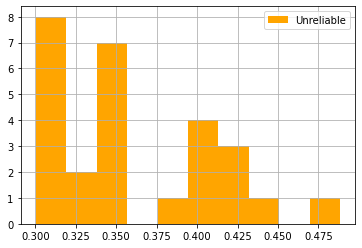

In [225]:
frequence_unreliable['support'].hist(label='Unreliable', color='orange')
plt.legend()
plt.show()

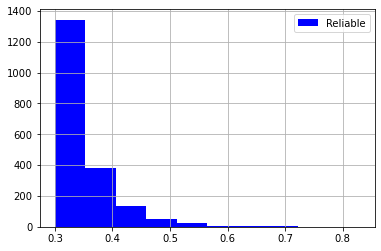

In [226]:
frequence_reliable['support'].hist(label='Reliable', color='blue')
plt.legend()
plt.show()

In [234]:
from mlxtend.frequent_patterns import association_rules

In [289]:
association_rules(frequence_unreliable, min_threshold=.0)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(time),(one),0.448140,0.488434,0.309268,0.690115,1.412914,0.090381,1.650825
1,(one),(time),0.488434,0.448140,0.309268,0.633184,1.412914,0.090381,1.504458


In [305]:
association_rules(frequence_reliable, metric='lift', min_threshold=1.5).sort_values('lift', ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(donald),(trump),0.325947,0.446409,0.319582,0.980473,2.196355,0.174076,28.349331
7,(trump),(donald),0.446409,0.325947,0.319582,0.715895,2.196355,0.174076,2.372550
21,(unit),"(would, state)",0.410262,0.464875,0.300016,0.731278,1.573063,0.109295,1.991367
18,"(would, state)",(unit),0.464875,0.410262,0.300016,0.645368,1.573063,0.109295,1.662959
3,"(trump, said)",(presid),0.379066,0.547933,0.325240,0.858002,1.565887,0.117536,3.183605
4,(presid),"(trump, said)",0.547933,0.379066,0.325240,0.593575,1.565887,0.117536,1.527794
9,(new),(york),0.644272,0.304495,0.304180,0.472131,1.550538,0.108003,1.317571
8,(york),(new),0.304495,0.644272,0.304180,0.998968,1.550538,0.108003,344.611917
1,(trump),(presid),0.446409,0.547933,0.378595,0.848090,1.547798,0.133993,2.975887
0,(presid),(trump),0.547933,0.446409,0.378595,0.690951,1.547798,0.133993,1.791272


A priori approximation

In [262]:
from mlxtend.frequent_patterns import apriori

te = TransactionEncoder()
te_ary = te.fit(reliable).transform(reliable)
reliableDF = pd.DataFrame(te_ary, columns=te.columns_)

te = TransactionEncoder()
te_ary = te.fit(unreliable).transform(unreliable)
unreliableDF = pd.DataFrame(te_ary, columns=te.columns_)

reliableApriori = apriori(reliableDF, min_support=0.6, use_colnames=True)
unreliableApriori = apriori(unreliableDF, min_support=0.3, use_colnames=True)

In [306]:
reliableApriori['length'] = reliableApriori['itemsets'].apply(lambda x: len(x))
unreliableApriori['length'] = unreliableApriori['itemsets'].apply(lambda x: len(x))

In [268]:
reliableApriori.sort_values('length', ascending=False).head()

,support,itemsets,length
10,0.638300,"(one, said)",2
11,0.601053,"(would, said)",2
0,0.687647,(also),1
1,0.649143,(like),1
2,0.644272,(new),1


In [307]:
unreliableApriori.sort_values('support', ascending=False).head()

,support,itemsets,length
12,0.488434,(one),1
20,0.448140,(time),1
13,0.430753,(peopl),1
8,0.426595,(like),1
16,0.423647,(said),1
